In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy import stats, integrate

import matplotlib.pyplot  as plt

from matplotlib.ticker import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables as tb

# Functions

In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] average absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


# Global parameters

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

In [4]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

In [5]:
dt = 1e3 # [ns] = 1us

v_d = 967.99*1e-6 # [mm/ns] = 967.99 [um/us] Drift velocity
Xe_ion = 11.14*1e-6 # [MeV] Xe ionization potential


d = 0.5 # [cm] average absorption depth (https://arxiv.org/pdf/1202.0721.pdf)
p = 15 # [bar] pressure
E = 3*p # [kV/cm] electric field (we ussually get E/p, so we define E in terms of p) (https://arxiv.org/pdf/1202.0721.pdf)
V = E*d # [kV] voltage

# EL_gain = 75 # [photons/e⁻] optical gain (https://iopscience.iop.org/article/10.1088/1748-0221/10/03/P03025/pdf)
# EL_gain = 700 # [photons/e⁻] optical gain (Francesc)
# EL_gain = 2500 # [photons/e⁻] optical gain (https://arxiv.org/pdf/1202.0721.pdf)
# EL_gain = EL_yield(E, p, d) # [photons/e⁻] optical gain (https://arxiv.org/pdf/physics/0702142.pdf)
# EL_gain = 140*V # [photons/e⁻] optical gain (https://arxiv.org/pdf/physics/0702142.pdf)
EL_gain = [500, 1000, 1500, 2000] # [photons/e⁻] optical gain 
print('EL_gain = ', EL_gain)

# e_lt = 16e5 # electron lifetime
e_lt = 10e6 # [ns] = 10 [ms] electron lifetime
# recombi = 0.026 # recombination factor (https://iopscience.iop.org/article/10.1088/1748-0221/10/03/P03025/pdf)
recombi = 0. # recombination factor (Ander)

z_max = 1.5e3 # [mm] Detector length/2
z_min = -z_max # symmetric detector

EL_gain =  [500, 1000, 1500, 2000]


# Data

## Units are fundamental units used in Geant4, ie:

### Length [L]: mm (milimeter)
### Time [T]: ns (nanosecond)
### Energy [E]: MeV (megaelectronvolt)


In [6]:
path = '/home/investigator/mariandbt/nexus/'

filename = os.path.join(path, "Xe_tank_bb0nu.next.h5")

In [7]:
# inside a .h5 file there are several objects, let's see which data-set (dst) we want
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Xe_tank_bb0nu.next.h5 (File) ''
Last modif.: '2023-03-27T15:22:22+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(36,)) ''
/MC/hits (Table(1499311,)) ''
/MC/particles (Table(317632,)) ''
/MC/sns_positions (Table(0,)) ''
/MC/sns_response (Table(0,)) ''



In [8]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
data = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [9]:
dst = data.copy()

# Electron distribution on time

### Number of events

In [10]:
n_events = len(dst['event_id'].unique())
n_events

10000

### Total time = initial time + drift time

In [11]:
drift_time = (z_max - dst['z'])/(v_d) # [ns]
dst['drift_time'] = drift_time
dst['tot_time'] = dst['time'] + drift_time

### Number of electrons = (energy deposition) * (EL gain) * (1 - recombination factor) * (lifetime factor)/ (ionization energy Xe)

In [12]:
n_e = np.floor(dst['energy']*(1 - recombi)*np.exp(-dst['drift_time']/e_lt)/Xe_ion)
dst['n_e'] = n_e

### Nph = Ne*(EL gain)

In [13]:
for count, EL_value in enumerate(EL_gain):
    dst['n_ph_'+str(count)] = np.floor(dst['n_e']*EL_value)

### Max S2 signal

In [14]:
# %%timeit

s2_hist = []

for count, EL_gain_value in enumerate(EL_gain):
    
    s2 = []
    
    # for ii in range(1000):
    for ii in range(n_events):

        dst_event = dst.loc[(dst['event_id'] == ii), :] # faster
    #     dst_event = dst.groupby("event_id").get_group(ii) # slower

        if (dst_event['tot_time'].max() - dst_event['tot_time'].min()) > dt:
            hist_bins = np.arange(dst_event['tot_time'].min(), dst_event['tot_time'].max(), dt)
        else:
            hist_bins = np.array([dst_event['tot_time'].min(), dst_event['tot_time'].max()])

    #     hist_weights = dst_event['n_ph']
        hist_weights = dst_event[str('n_ph_' + str(count))]
        events, bins = np.histogram(dst_event['tot_time'], hist_bins, weights = hist_weights);

        s2.append(events.max())
        
    s2_hist.append(np.array(s2))
    

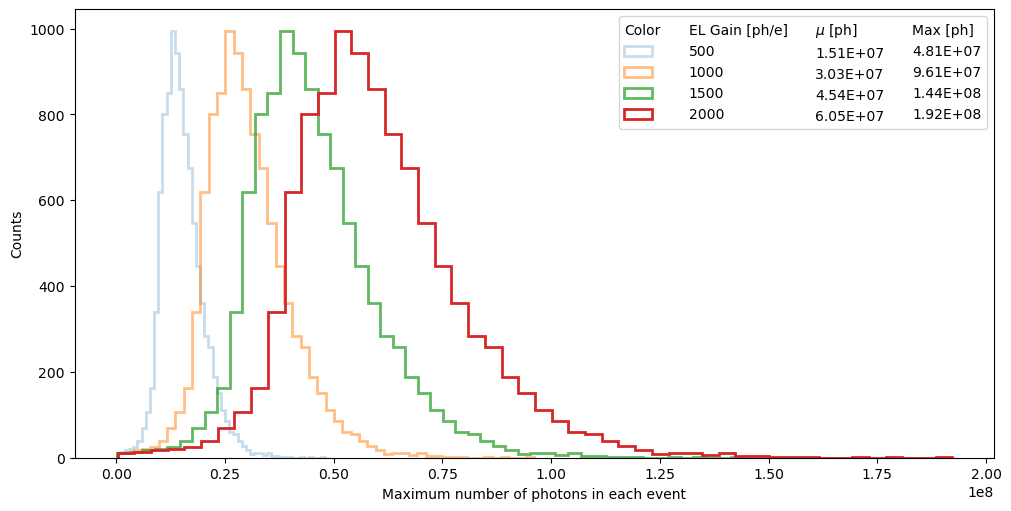

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

#_________plot_settings_________________________________________________


s2_mean = []
s2_max = []

for count, EL_gain_value in enumerate(EL_gain):
# for count, EL_gain_value in enumerate([500]):

    events, bins, bars = ax.hist(s2_hist[count], 50, density=False, 
                                 label='S2 photon distribution', 
                                 histtype='step', 
                                 alpha = (0.25 + 0.25*count),
                                 lw = 2
                                )

    s2_mean.append(s2_hist[count].mean())
    s2_max.append(s2_hist[count].max())

# ax.set_xlabel('Number of photons in S2');
ax.set_xlabel('Maximum number of photons in each event');
ax.set_ylabel('Counts');

hand, labl = ax.get_legend_handles_labels()
s2_mean = np.array(s2_mean)
s2_max = np.array(s2_max)

# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#Create organized list containing all handles for table. Extra represent empty space
legend_handle = np.concatenate([[extra], hand, 
                                [extra]*(len(hand) + 1),
                                [extra]*(len(hand) + 1),
                                [extra]*(len(hand) + 1)
                               ])

#Define the labels
label_empty = [""]
label_markers = [r"Color"]
label_EL = [r"EL Gain [ph/e]", '%.0f'%(EL_gain[0]), '%.0f'%(EL_gain[1]), '%.0f'%(EL_gain[2]), '%.0f'%(EL_gain[3])]
label_s2mean = [r"$\mu$ [ph]", '%.2E'%(s2_mean[0]), '%.2E'%(s2_mean[1]), '%.2E'%(s2_mean[2]), '%.2E'%(s2_mean[3])]
label_s2max = [r"Max [ph]", '%.2E'%(s2_max[0]), '%.2E'%(s2_max[1]), '%.2E'%(s2_max[2]), '%.2E'%(s2_max[3])]

#organize labels for table construction
legend_labels = np.concatenate([label_markers, label_empty*len(hand), 
                                label_EL, label_s2mean, label_s2max])

#Create legend
ax.legend(legend_handle, legend_labels, 
          loc = 'best', ncol = 4, shadow = False, handletextpad = -2)
